# Vaccine Sentiment Classification
*by Nefeli Tavoulari*

#### In this notebook I classify tweets as Neutral, Pro-vax or Anti-vax.

## Install Dependencies

In [1]:
!pip install -U torch==1.8.0 torchtext==0.9.0

     |████████████████████████████████| 735.5 MB 12 kB/s 
     |████████████████████████████████| 7.1 MB 25.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.
ERROR: You must give at least one requirement to install (see "pip help install")


## Import Packages

In [2]:
%matplotlib inline
import io
import re
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from wordcloud import WordCloud
import nltk
import re
import csv
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

import torch
import torch.nn as nn
from torchtext.legacy import data   
from torchtext.vocab import GloVe
from torchtext.legacy.data import BucketIterator
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dsets

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, accuracy_score, mean_absolute_error

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Upload dataset - Create dataframe

In [3]:
upload_train = files.upload()

Saving vs_train.csv to vs_train.csv


In [4]:
upload_dev = files.upload()

Saving vs_dev.csv to vs_dev.csv


## Upload Glove Embeddings

In [5]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [6]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip
# free some space
!rm glove.twitter.27B.zip

--2021-12-19 19:37:35--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-12-19 19:37:36--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.00MB/s    in 4m 47s  

2021-12-19 19:42:24 (5.05 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.2

In [690]:
gloveModel = load_glove_model("glove.twitter.27B.25d.txt")
dim = 25
#
#gloveModel = load_glove_model("glove.twitter.27B.50d.txt")
#dim = 50
#
#gloveModel = load_glove_model("glove.twitter.27B.100d.txt")
#dim = 100
#
#gloveModel = load_glove_model("glove.twitter.27B.200d.txt")
#dim = 200


Loading Glove Model
1193514 words loaded!


In [691]:
train_df = pd.read_csv(io.BytesIO(upload_train['vs_train.csv']))
dev_df = pd.read_csv(io.BytesIO(upload_dev['vs_dev.csv']))

In [692]:
print(train_df) # training data

       Unnamed: 0                                              tweet  label
0               0  Sip N Shop Come thru right now #Marjais #Popul...      0
1               1  I don't know about you but My family and I wil...      1
2               2  @MSignorile Immunizations should be mandatory....      2
3               3  President Obama spoke in favor of vaccination ...      0
4               4  "@myfoxla: Arizona monitoring hundreds for mea...      0
...           ...                                                ...    ...
15971       15971  @Salon if u believe the anti-vax nutcases caus...      1
15972       15972  How do you feel about parents who don't #vacci...      0
15973       15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974       15974  Finance Minister: Budget offers room to procur...      0
15975       15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 3 columns]


In [693]:
print(dev_df) # validation data

      Unnamed: 0                                              tweet  label
0              0  @user They had a massive surge in with covid d...      1
1              1  Required vaccines for school: Parents and guar...      0
2              2  “@KCStar: Two more Johnson County children hav...      0
3              3  NV can do better. Which states are the best (a...      2
4              4  Nothing like killing ourselves w/ our own fear...      2
...          ...                                                ...    ...
2277        2277  RT @abc7: Number of measles cases reported in ...      0
2278        2278  Evidence points to the idea that "measles affe...      0
2279        2279  Where's @SavedYouAClick "@voxdotcom: Why you s...      2
2280        2280  Some of my favorite people have autism. If tha...      2
2281        2281  Coronavirus: The married couple behind the suc...      0

[2282 rows x 3 columns]


## Remove empty / duplicate tweets

In [694]:
train_df.dropna(subset = ["tweet"], inplace=True)
train_df.drop_duplicates(subset = ["tweet"], inplace=True)

dev_df.dropna(subset = ["tweet"], inplace=True)

train_df.drop(['Unnamed: 0'], axis=1, inplace = True) 
dev_df.drop(['Unnamed: 0'], axis=1, inplace = True) 

print(train_df.shape)
print(dev_df.shape)

(15881, 2)
(2282, 2)


## Clean text

In [695]:
def clean_text(text):
  text = text.lower()                                           # lowercase
  text = text.strip()                                           # remove white spaces
  #text = ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",text).split())   # remove twitter user accounts
  text = re.sub(r'http\S+', ' ', text)                          # remove urls
  text = re.sub('[^A-Za-z0-9]+', ' ', text)                     # remove special characters
  # perform lemmatization
  cleaned_text = ""
  for word in text.split() :
    if word in stop_words:                                      # remove stopwords
      continue
    temp = lemmatizer.lemmatize(word)                           # lemmatize
    #temp = snowball.stem(word)
    #temp = lancaster.stem(word)
    #temp = porter.stem(word)
    cleaned_text += (temp + " ")
  return cleaned_text

In [696]:
cleaned_text = []                                  # clean training data
for line in train_df["tweet"]:
  cleaned_text.append(clean_text(line))
cleaned_text_val = []                              # clean validation data
for line in dev_df["tweet"]:
  cleaned_text_val.append(clean_text(line))

train_df = train_df.assign(clean_tweet = lambda x: cleaned_text)
dev_df = dev_df.assign(clean_tweet = lambda x: cleaned_text_val)

train_df.drop(['tweet'], axis=1, inplace = True) 
dev_df.drop(['tweet'], axis=1, inplace = True) 

In [697]:
total_df = train_df.append(dev_df)
total_df.shape

(18163, 2)

### Use Word Embeddings

In [698]:
vocab = {}
for row in range(0, total_df.shape[0]):
  vocab[row] = []
i = 0
for tweet in total_df["clean_tweet"]: # each tweet
  count = np.zeros(dim)  
  for word in tweet.split():
    if (word in gloveModel):
      count += gloveModel[word]
  for num in count/dim:
    vocab[i].append(num)
  i += 1

In [699]:
df = pd.DataFrame.from_dict(vocab, orient='index')
#df = df.transpose()
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,-0.074209,0.174633,-0.018545,-0.030889,-0.051354,-0.050267,0.174427,0.031691,-0.011138,0.126046,-0.059712,-0.051399,-0.903162,-0.034106,-0.020152,-0.055038,0.026370,-0.129461,-0.080249,-0.004640,-0.054612,-0.052254,0.154567,0.132431,0.081430
1,-0.096885,0.198095,-0.036882,-0.027684,-0.064159,-0.100399,0.301494,-0.063744,-0.024514,0.023850,-0.076308,0.067945,-0.922091,0.012661,0.092259,0.003399,0.080930,-0.173531,0.035397,-0.089007,-0.018312,0.031987,-0.018892,0.075888,-0.009154
2,-0.040021,0.258818,-0.079311,-0.117769,-0.042948,-0.029355,0.461787,-0.403149,-0.017695,0.054543,-0.156850,0.092332,-1.501643,0.117023,0.250349,0.064133,0.097205,-0.161577,0.073152,-0.167225,-0.092468,0.156980,0.077036,-0.134057,-0.034076
3,0.035770,0.332920,-0.080705,-0.037391,0.115634,-0.350312,0.212475,-0.222832,0.052082,-0.137239,0.060121,0.017058,-1.428052,0.010468,0.194881,-0.033724,-0.066033,-0.011467,0.148273,-0.270828,0.099840,0.127823,-0.090725,-0.291199,-0.178715
4,0.010700,0.106362,-0.045609,-0.027944,-0.061994,-0.040095,0.175118,-0.341968,-0.027564,0.030356,0.145610,0.041177,-0.824256,0.154942,0.065042,-0.105719,0.084132,0.015968,0.198163,-0.051885,-0.170522,-0.036614,-0.022403,-0.270810,-0.051687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18158,0.068196,0.232128,0.084904,-0.170493,0.003719,-0.088877,0.527260,0.026907,-0.020015,0.118675,-0.070675,0.160058,-1.776028,0.137248,0.220457,-0.129746,0.188813,-0.176381,0.013349,-0.074251,-0.018184,0.080001,0.130804,-0.048743,-0.079874
18159,0.135183,0.103666,-0.183617,0.069301,0.194723,-0.035908,0.397737,-0.391050,0.025930,0.104589,0.088990,0.076809,-1.422444,0.272032,0.283920,0.007851,0.152214,0.103808,0.302962,-0.237584,-0.146742,0.087779,0.016166,-0.096209,-0.205875
18160,0.012991,0.094557,0.045770,0.002997,-0.000554,-0.057806,0.143313,-0.167676,-0.063106,-0.008966,-0.018790,0.015629,-0.523774,0.007312,0.009046,-0.010261,0.048903,-0.101382,0.002362,-0.044212,-0.071073,0.078687,0.016030,-0.094016,-0.049905
18161,-0.094936,0.232104,-0.101476,0.067977,0.059048,-0.099540,0.410378,-0.217557,-0.181291,0.041748,-0.102457,0.161872,-1.260708,-0.074044,0.073398,0.053315,0.095231,-0.091243,0.197620,-0.116799,0.012127,0.090565,-0.012347,-0.159820,-0.066846


In [700]:
train = df.iloc[:train_df.shape[0], :]
dev = df.iloc[train_df.shape[0]:, :]

x = torch.tensor(df.values, dtype=torch.float)
y = torch.tensor(total_df['label'].values)

x_train = torch.tensor(train.values, dtype=torch.float)
y_train = torch.tensor(train_df['label'].values)

x_dev = torch.tensor(dev.values, dtype=torch.float)
y_dev = torch.tensor(dev_df['label'].values)

# Initialize dataloaders
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

dev_dataset = TensorDataset(x_dev, y_dev)
dev_dataloader = DataLoader(dev_dataset, batch_size=64, shuffle=True)

## Model

In [701]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.batchnorm1 = nn.BatchNorm1d(H1)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.sigmoid = nn.Sigmoid()
        self.linear3 = nn.Linear(H2, D_out)
        
        #self.batchnorm2 = nn.BatchNorm1d(H2)
        #self.batchnorm3 = nn.BatchNorm1d(D_out)
        #self.linear4 = nn.Linear(H3, D_out)
        #self.linear5 = nn.Linear(H4, D_out)
        #self.dropout = nn.Dropout(p=0.2)
        #self.softmax = nn.Softmax(dim=1)
        #self.logsoftmax = nn.LogSoftmax()
        #self.softmin = nn.Softmin()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        #out = self.dropout(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        #out = self.dropout(out)
        out = self.linear3(out)

        # out = self.relu(out)
        # out = self.linear4(out)
        #out = self.batchnorm3(out)
        #out = self.relu(out)
        #out = self.batchnorm2(out)
        #out = self.relu(out)    
        #out = self.softmax(out)
        #out = self.softmin(out)
        return out

In [702]:
#Define layer sizes
D_in = x.shape[1]
H1 = 64
H2 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, optimizer
model = Net(D_in, H1, H2, D_out)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2, weight_decay=0.01)
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

In [703]:
model

Net(
  (linear1): Linear(in_features=25, out_features=64, bias=True)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (sigmoid): Sigmoid()
  (linear3): Linear(in_features=32, out_features=3, bias=True)
)

In [704]:
epoch_loss = []
epoch_loss_dev = []
epoch_acc = []
epoch_acc_dev = []

for epoch in range(100):

  batch_losses = []
  batch_acc = 0
  total = 0
  total_dev = 0
  loss = 0
  pred_proba = []

  # training
  model.train()
  for x_batch, y_batch in train_dataloader:  # for every batch
    y_pred = model(x_batch).squeeze(1)
    loss = criterion(y_pred, y_batch)
    batch_losses.append(loss)
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

    # Total number of labels
    total += y_batch.size(0)
    # Total correct predictions
    _,pred_label = torch.max(y_pred, dim = 1)
    batch_acc += (pred_label == y_batch).sum()

  # validation    
  with torch.no_grad():
    batch_losses_dev = []
    batch_acc_dev = 0
    model.eval()
    for x_batch, y_batch in dev_dataloader:
        y_dev_pred = model(x_batch).squeeze(1)
        prob = F.softmax(y_dev_pred, dim=1)   # probability that an instance belogs to each class
        #print(prob.shape)
        for i in prob:
          pred_proba.append(i.tolist())
        loss_dev = criterion(y_dev_pred, y_batch)
        batch_losses_dev.append(loss_dev)
        # number of labels
        total_dev += y_batch.size(0)
        # correct predictions
        _,pred_label = torch.max(y_dev_pred, dim = 1)  # get max probability
        batch_acc_dev += (pred_label == y_batch).sum()


  accuracy = batch_acc/total
  accuracy_dev = batch_acc_dev/total_dev

  train_loss = sum(batch_losses)/len(train_dataloader)
  valid_loss = sum(batch_losses_dev)/len(dev_dataloader)

  epoch_loss.append(train_loss)
  epoch_loss_dev.append(valid_loss)
  epoch_acc.append(accuracy)
  epoch_acc_dev.append(accuracy_dev)

  print(f"Epoch {epoch:3}: | Train Loss = {train_loss:.5f} | Train Accuracy = {accuracy:.5f} | Validation Loss = {valid_loss:.5f} | Validation Accuracy = {accuracy_dev:.5f} ")

Epoch   0: | Train Loss = 1.04129 | Train Accuracy = 0.45772 | Validation Loss = 0.98827 | Validation Accuracy = 0.54119 
Epoch   1: | Train Loss = 0.96499 | Train Accuracy = 0.55230 | Validation Loss = 0.94382 | Validation Accuracy = 0.56442 
Epoch   2: | Train Loss = 0.93312 | Train Accuracy = 0.56898 | Validation Loss = 0.91702 | Validation Accuracy = 0.58282 
Epoch   3: | Train Loss = 0.90973 | Train Accuracy = 0.58183 | Validation Loss = 0.89897 | Validation Accuracy = 0.59378 
Epoch   4: | Train Loss = 0.89113 | Train Accuracy = 0.59341 | Validation Loss = 0.87897 | Validation Accuracy = 0.59465 
Epoch   5: | Train Loss = 0.87481 | Train Accuracy = 0.59820 | Validation Loss = 0.86704 | Validation Accuracy = 0.60473 
Epoch   6: | Train Loss = 0.86499 | Train Accuracy = 0.60588 | Validation Loss = 0.85483 | Validation Accuracy = 0.61043 
Epoch   7: | Train Loss = 0.85676 | Train Accuracy = 0.60720 | Validation Loss = 0.84690 | Validation Accuracy = 0.60649 
Epoch   8: | Train Loss 

### Evaluation

In [705]:
model.eval()
true = y_dev
pred = model(x_dev).squeeze(1)
after_train = criterion(pred, true) 
print('Test loss after Training' , after_train.item())

Test loss after Training 0.772049069404602


In [706]:
_,pred_label = torch.max(pred, dim = 1)

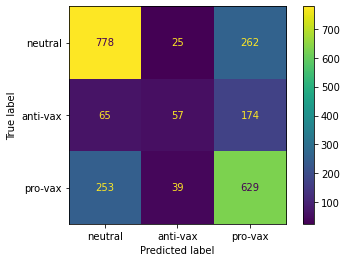

In [707]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
df = pd.DataFrame({'true':true.numpy()})
df2 = pd.DataFrame({'pred':pred_label.numpy()})
cm = confusion_matrix(true.numpy(), pred_label.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

In [708]:
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(true.numpy(), pred_label.numpy(), average='micro'))
print()

Precision-Recall-F1 - Test Data :
(0.6415425065731815, 0.6415425065731815, 0.6415425065731815, None)



In [709]:
print(classification_report(true.numpy(), pred_label.numpy()))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1065
           1       0.47      0.19      0.27       296
           2       0.59      0.68      0.63       921

    accuracy                           0.64      2282
   macro avg       0.59      0.54      0.54      2282
weighted avg       0.63      0.64      0.63      2282



In [710]:
prob = F.softmax(pred, dim=1)
pred_proba = []
for i in prob:
  pred_proba.append(i.tolist())

In [711]:
macro_roc_auc_ovo = roc_auc_score(true.tolist(), pred_proba, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(true.tolist(), pred_proba, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(true.tolist(), pred_proba, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(true.tolist(), pred_proba, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print()
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.778982 (macro),
0.785546 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.793916 (macro),
0.793266 (weighted by prevalence)


### Plots

In [712]:
# probabilities
df_prob = pd.DataFrame(pred_proba)
df_prob

,0,1,2
0,0.372304,0.404163,0.223533
1,0.504933,0.176520,0.318546
2,0.690295,0.054267,0.255438
3,0.391639,0.086329,0.522032
4,0.347850,0.148051,0.504098
...,...,...,...
2277,0.634147,0.054649,0.311204
2278,0.412039,0.283291,0.304670
2279,0.284376,0.072318,0.643306
2280,0.123067,0.040144,0.836789


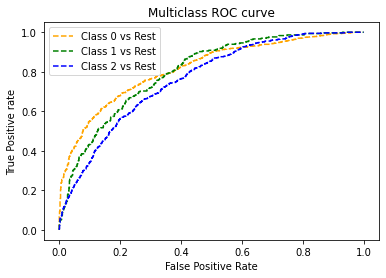

In [713]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true, df_prob[i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

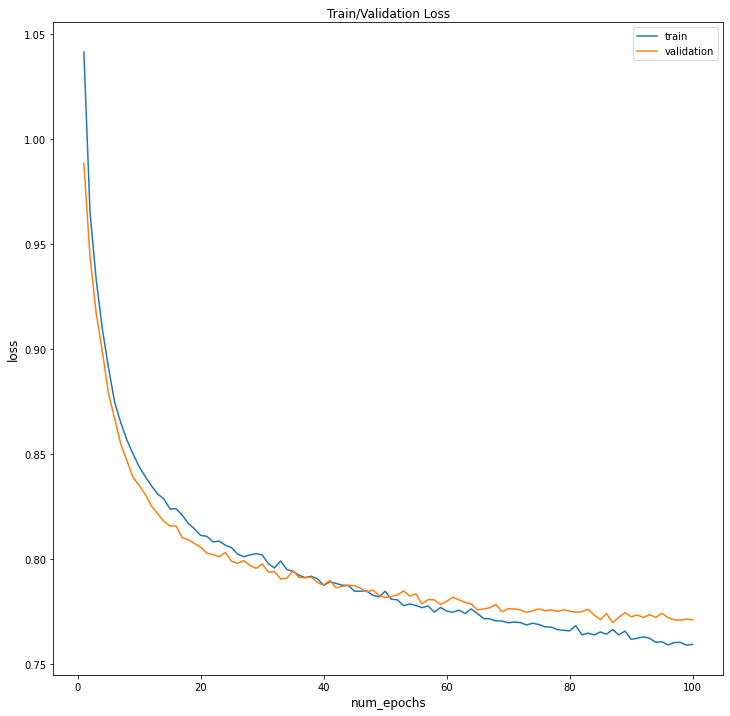

In [714]:
def plot_graph_loss(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , epoch_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_loss_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(['train', 'validation']);

plot_graph_loss(100)

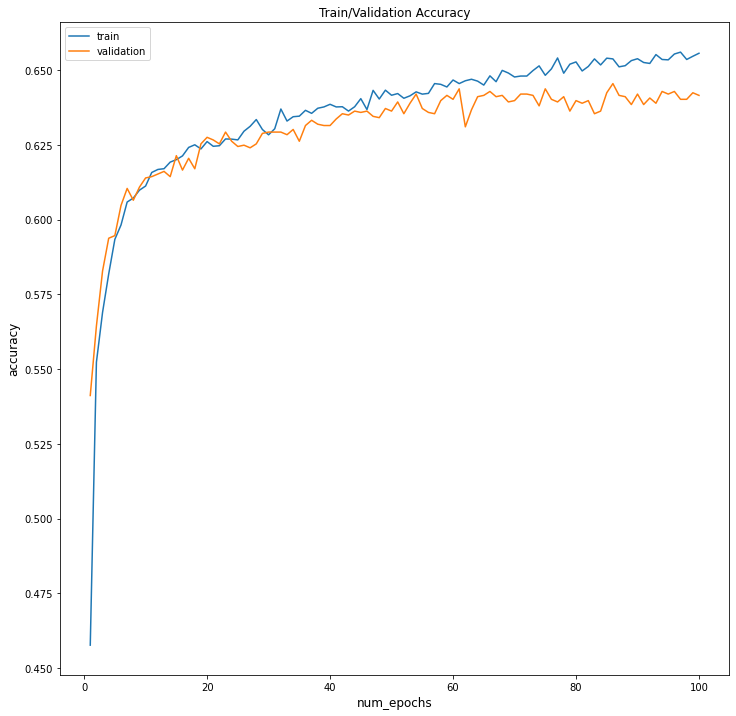

In [715]:
def plot_graph_acc(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Accuracy")
    plt.plot(list(np.arange(epochs) + 1) , epoch_acc, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_acc_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(['train', 'validation']);

plot_graph_acc(100)    

## Second Model

In [716]:
class Net2(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.batchnorm1 = nn.BatchNorm1d(H1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(H1, H2)
        self.sigmoid = nn.Sigmoid()
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        out = self.linear3(out)
        out = self.logsoftmax(out)
        return out

In [717]:
#Define layer sizes
D_in = x.shape[1]
H1 = 128
H2 = 64
H3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, optimizer, loss function
model = Net2(D_in, H1, H2, H3, D_out)

loss_func = nn.NLLLoss()                    # with softmax in output of model

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2, weight_decay=0.01)
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

In [718]:
model

Net2(
  (linear1): Linear(in_features=25, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=3, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [719]:
epoch_loss = []
epoch_loss_dev = []
epoch_acc = []
epoch_acc_dev = []

for epoch in range(100):

  batch_losses = []
  batch_acc = 0
  total = 0
  total_dev = 0
  loss = 0

  # training
  model.train()
  for x_batch, y_batch in train_dataloader:  # for every batch
    y_pred = model(x_batch).squeeze(1)
    loss = loss_func(y_pred, y_batch)
    batch_losses.append(loss)
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

    # Total number of labels
    total += y_batch.size(0)
    # Total correct predictions
    _,pred_label = torch.max(y_pred, dim = 1)
    batch_acc += (pred_label == y_batch).sum()

  # validation    
  with torch.no_grad():
    batch_losses_dev = []
    batch_acc_dev = 0
    model.eval()

    for x_batch, y_batch in dev_dataloader:
        y_dev_pred = model(x_batch).squeeze(1)
        loss_dev = loss_func(y_dev_pred, y_batch)
        batch_losses_dev.append(loss_dev)
        # number of labels
        total_dev += y_batch.size(0)
        # correct predictions
        _,pred_label = torch.max(y_dev_pred, dim = 1)  # get max probability
        batch_acc_dev += (pred_label == y_batch).sum()

  accuracy = batch_acc/total
  accuracy_dev = batch_acc_dev/total_dev

  train_loss = sum(batch_losses)/len(train_dataloader)
  valid_loss = sum(batch_losses_dev)/len(dev_dataloader)

  epoch_loss.append(train_loss)
  epoch_loss_dev.append(valid_loss)
  epoch_acc.append(accuracy)
  epoch_acc_dev.append(accuracy_dev)

  print(f"Epoch {epoch:3}: | Train Loss = {train_loss:.5f} | Train Accuracy = {accuracy:.5f} | Validation Loss = {valid_loss:.5f} | Validation Accuracy = {accuracy_dev:.5f} ")

Epoch   0: | Train Loss = 2.91625 | Train Accuracy = 0.26560 | Validation Loss = 2.04246 | Validation Accuracy = 0.46713 
Epoch   1: | Train Loss = 1.54754 | Train Accuracy = 0.48001 | Validation Loss = 1.23204 | Validation Accuracy = 0.51840 
Epoch   2: | Train Loss = 1.12217 | Train Accuracy = 0.54165 | Validation Loss = 1.03615 | Validation Accuracy = 0.55828 
Epoch   3: | Train Loss = 1.00270 | Train Accuracy = 0.56653 | Validation Loss = 0.96735 | Validation Accuracy = 0.57932 
Epoch   4: | Train Loss = 0.95103 | Train Accuracy = 0.57912 | Validation Loss = 0.92814 | Validation Accuracy = 0.58545 
Epoch   5: | Train Loss = 0.91868 | Train Accuracy = 0.59159 | Validation Loss = 0.90109 | Validation Accuracy = 0.59202 
Epoch   6: | Train Loss = 0.89632 | Train Accuracy = 0.59795 | Validation Loss = 0.87967 | Validation Accuracy = 0.60605 
Epoch   7: | Train Loss = 0.88115 | Train Accuracy = 0.60097 | Validation Loss = 0.86590 | Validation Accuracy = 0.60386 
Epoch   8: | Train Loss 

### Evaluation

In [720]:
model.eval()
true = y_dev
pred = model(x_dev).squeeze(1)
after_train = criterion(pred, true) 
print('Test loss after Training' , after_train.item())

Test loss after Training 0.7625619769096375


In [721]:
_,pred_label = torch.max(pred, dim = 1)

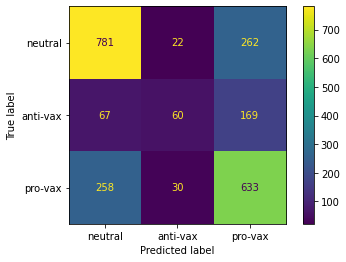

In [722]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
df = pd.DataFrame({'true':true})
df2 = pd.DataFrame({'pred':pred_label})
cm = confusion_matrix(true, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

In [723]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(true, pred_label, average='micro'))

Precision-Recall-F1 - Training Data :
(0.6459246275197196, 0.6459246275197196, 0.6459246275197196, None)


In [724]:
print(classification_report(true, pred_label))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1065
           1       0.54      0.20      0.29       296
           2       0.59      0.69      0.64       921

    accuracy                           0.65      2282
   macro avg       0.61      0.54      0.55      2282
weighted avg       0.64      0.65      0.63      2282



### Plots

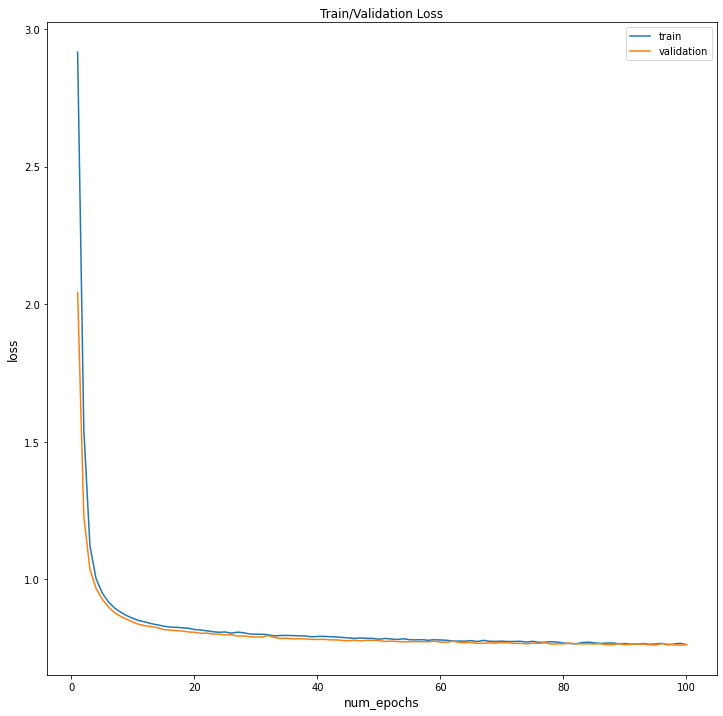

In [725]:
def plot_graph_loss(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , epoch_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_loss_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(['train', 'validation']);
plot_graph_loss(100)

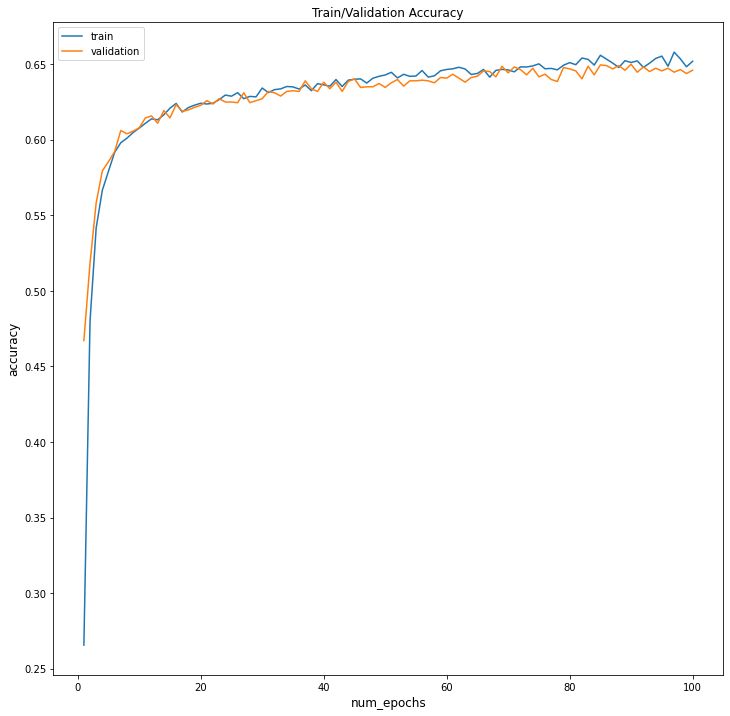

In [726]:
def plot_graph_acc(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Accuracy")
    plt.plot(list(np.arange(epochs) + 1) , epoch_acc, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_acc_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(['train', 'validation']);
plot_graph_acc(100)    